In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Data loading

In [2]:
df = pd.read_csv('time-series.csv')
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


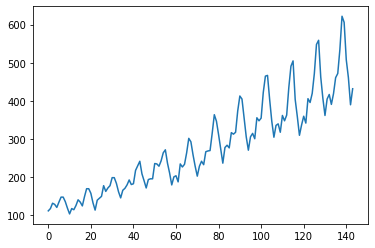

In [3]:
values = df.iloc[:,-1].to_numpy().reshape(-1,1)

plt.plot(values)
plt.show()

# Data preprocessing

In [4]:
values[:5]

array([[112],
       [118],
       [132],
       [129],
       [121]])

In [5]:
# min max scale your data
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(values)

In [6]:
normalized_values[:5]

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]])

In [7]:
# For example
# data = [1,2,3,4,5,6,7,8,9,10]
# seq_length = 4
# x = [[1,2,3,4],[2,3,4,5],[3,4,5,6],[4,5,6,7],[5,6,7,8],[6,7,8,9]]
# y = [5,6,7,8,9,10]
# 5 is the label of [1,2,3,4]

seq_length = 4

def label_data(data, seq_length):
  x = []
  y = []

  for i in range(len(data)-seq_length):
    x.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return x,y 

x,y = label_data(normalized_values, seq_length)

In [8]:
# train test split 80%/20%
train_size = int(0.8*len(y))
test_size = int(0.2*len(y))

trainX = Variable(torch.Tensor(x[:train_size]))
trainY = Variable(torch.Tensor(y[:train_size]))

testX = Variable(torch.Tensor(x[train_size:]))
testY = Variable(torch.Tensor(y[train_size:]))


#Model architecture

In [21]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
    
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    # Hint: Initialize two pytorch variables with zeros
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_())
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_())

    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    
    out = self.fc(out[:, -1, :]) 
    return out

#Model training

In [46]:
# Initialize the model

num_classes = 1
input_size = 1
hidden_size = 20
num_layers = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)


In [47]:
loss_function = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate)

num_epochs = 1000
for epoch in range(num_epochs):
  # batch training
  optimizer.zero_grad()

  outputs = lstm(trainX)
  labels = trainY

  loss = loss_function(outputs,labels)
  loss.backward()
  optimizer.step()
  
  if epoch % 100 == 0:
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

Epoch:1, Loss:0.2037
Epoch:101, Loss:0.0048
Epoch:201, Loss:0.0029
Epoch:301, Loss:0.0023
Epoch:401, Loss:0.0022
Epoch:501, Loss:0.0021
Epoch:601, Loss:0.0021
Epoch:701, Loss:0.0021
Epoch:801, Loss:0.0020
Epoch:901, Loss:0.0020


#Model evaluation

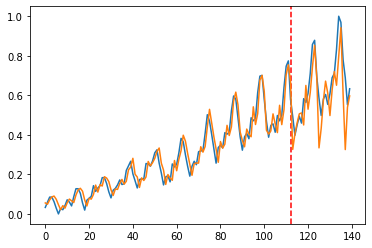

In [48]:
# eval mode
lstm.eval() 

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

preds = lstm(dataX).detach().numpy()
labels = dataY

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(labels)
plt.plot(preds)
plt.show()
